# Connections among non-trained patterns
This notebook is to study the weird connections that I am getting between the non-trained patterns. 

We start first by loading the usual libraries

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from network import BCPNN, NetworkManager
from data_transformer import build_ortogonal_patterns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

#### Git loading

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '359adc708eff204fc520bd9d21e33c1a38b78c09'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## Network training

In [3]:
hypercolumns = 2
minicolumns = 10
n_patterns = 5  # Number of patterns

patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

# Build the network
tau_z_pre = 0.500
tau_z_post = 0.125

nn = BCPNN(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre)

We get the network manager

In [4]:
dt = 0.001
T_training = 1
time_training = np.arange(0, T_training, dt)
T_ground = 0.5
time_ground = np.arange(0, T_ground, dt)
values_to_save = ['o', 'a', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w']

manager = NetworkManager(nn=nn, values_to_save=values_to_save)

We preform the training then

In [5]:
repetitions = 20
resting_state = False
for i in range(repetitions):
    print('repetitions', i)
    for pattern in patterns:
        nn.k = 1.0
        manager.run_network(time=time_training, I=pattern)
        nn.k = 0.0
        if resting_state:
            manager.run_network(time=time_ground)

history = manager.history

repetitions 0
repetitions 1
repetitions 2
repetitions 3
repetitions 4
repetitions 5
repetitions 6
repetitions 7
repetitions 8
repetitions 9
repetitions 10
repetitions 11
repetitions 12
repetitions 13
repetitions 14
repetitions 15
repetitions 16
repetitions 17
repetitions 18
repetitions 19


We load all the quantities of interest

In [6]:
history = manager.history

if resting_state:
    T_total = n_patterns * repetitions * (T_training + T_ground)
else:
    T_total = n_patterns * repetitions * T_training

total_time = np.arange(0, T_total, dt)

z_pre_hypercolum = history['z_pre'][..., :minicolumns]
z_post_hypercolum = history['z_post'][..., :minicolumns]
o_hypercolum = history['o'][..., :minicolumns]
p_pre_hypercolum = history['p_pre'][..., :minicolumns]
p_post_hypercolum = history['p_post'][..., :minicolumns]

# Take coactivations
p_co = history['p_co']
z_co = history['z_co']
w = history['w']

traces_to_plot = [6, 7, 8]
coactivations_to_plot = [(6, 7), (8, 7)]
labels_of_coactivations = ['67', '87']

p_co_list = []
z_co_list = []
w_list = []
aux_list = []

for (x, y) in coactivations_to_plot:
    p_co_list.append(p_co[:, x, y])
    z_co_list.append(z_co[:, x, y])
    w_list.append(w[:, x, y])

for p_co, (x, y) in zip(p_co_list, coactivations_to_plot):
    aux_list.append(p_co / (p_pre_hypercolum[:, x] * p_post_hypercolum[:, y]))


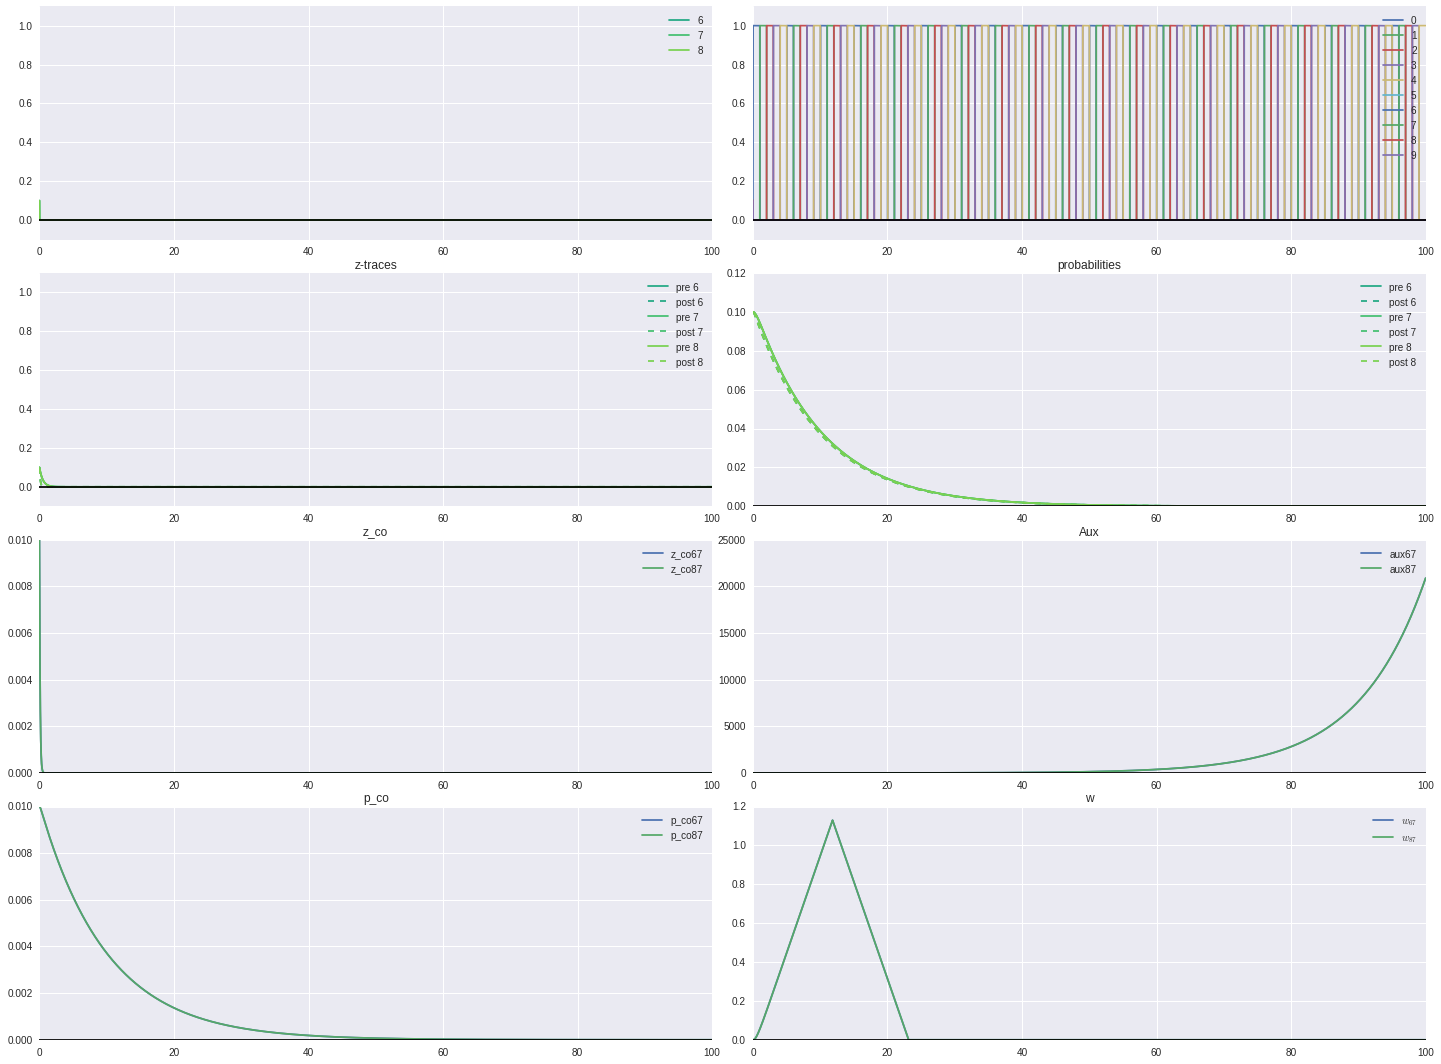

In [7]:
import seaborn as sns
sns.set_context(font_scale=2.0)

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=minicolumns)

# Plot the traces
fig = plt.figure(figsize=(20, 15))
ax11 = fig.add_subplot(421)
ax12 = fig.add_subplot(422)
ax21 = fig.add_subplot(423)
ax22 = fig.add_subplot(424)
ax31 = fig.add_subplot(425)
ax32 = fig.add_subplot(426)
ax41 = fig.add_subplot(427)
ax42 = fig.add_subplot(428)

fig.tight_layout()

for index in range(minicolumns):
    # Plot ALL the activities
    ax12.plot(total_time, o_hypercolum[:, index], label=str(index))


for index in traces_to_plot:
    # Plot activities
    ax11.plot(total_time, o_hypercolum[:, index], color=cmap(norm(index)), label=str(index))
    # Plot the z post and pre traces in the same graph
    ax21.plot(total_time, z_pre_hypercolum[:, index], color=cmap(norm(index)), label='pre ' + str(index))
    ax21.plot(total_time, z_post_hypercolum[:, index], color=cmap(norm(index)), linestyle='--', label='post ' + str(index))

    # Plot the pre and post probabilties in the same graph
    ax22.plot(total_time, p_pre_hypercolum[:, index], color=cmap(norm(index)), label='pre ' + str(index))
    ax22.plot(total_time, p_post_hypercolum[:, index], color=cmap(norm(index)), linestyle='--', label='post ' + str(index))

# Plot z_co and p_co in the same graph
for z_co, label in zip(z_co_list, labels_of_coactivations):
    ax31.plot(total_time, z_co, label='z_co' + label)

# Plot the aux quantity
for aux, label in zip(aux_list, labels_of_coactivations):
    ax32.plot(total_time, aux, label='aux' + label)


# Plot the coactivations probabilities
for p_co, label in zip(p_co_list, labels_of_coactivations):
    ax41.plot(total_time, p_co, '-', label='p_co' + label)

# Plot the weights
for w, label in zip(w_list, labels_of_coactivations):
    ax42.plot(total_time, w, label=r'$w_{' + label +'}$')


axes = fig.get_axes()
for ax in axes:
    ax.set_xlim([0, T_total])
    ax.legend()
    ax.axhline(0, color='black')


ax11.set_ylim([-0.1, 1.1])
ax12.set_ylim([-0.1, 1.1])
ax21.set_ylim([-0.1, 1.1])

ax21.set_title('z-traces')
ax22.set_title('probabilities')
ax31.set_title('z_co')
ax32.set_title('Aux')
ax41.set_title('p_co')
ax42.set_title('w')

plt.show()

#### Connectivity matrix

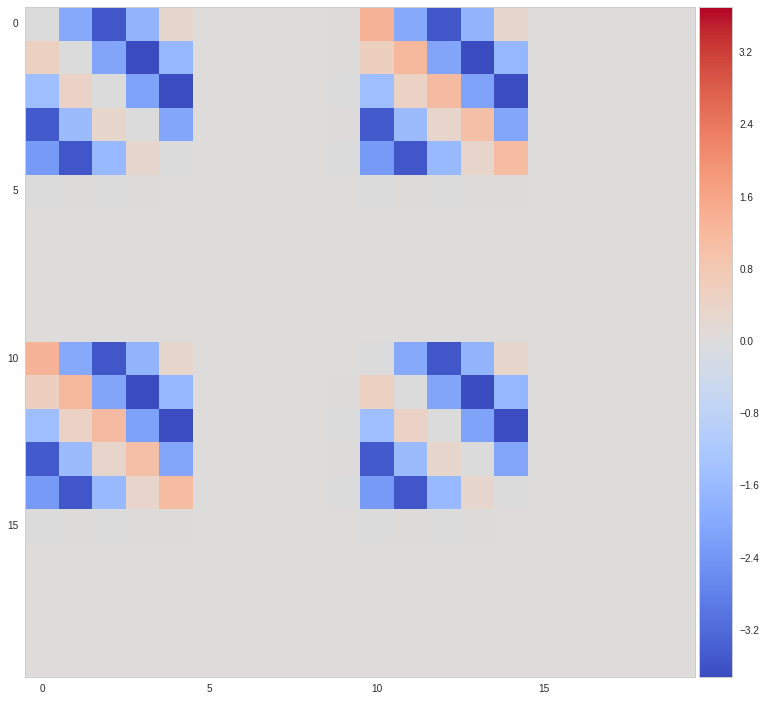

In [8]:
sns.set_style("whitegrid", {'axes.grid' : False})
w = nn.w
aux_max = np.max(np.abs(w))

cmap = 'coolwarm'
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(111)
im1 = ax1.imshow(w, cmap=cmap, interpolation='None', vmin=-aux_max, vmax=aux_max)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, ax=ax1, cax=cax1)

## Network recalling

In [9]:
nn.k = 0
manager.empty_history()
nn.reset_values(keep_connectivity=True)
T_recalling = 10.0
time_recalling = np.arange(0, T_recalling + dt, dt)

manager.run_network(time=time_recalling)

history = manager.history

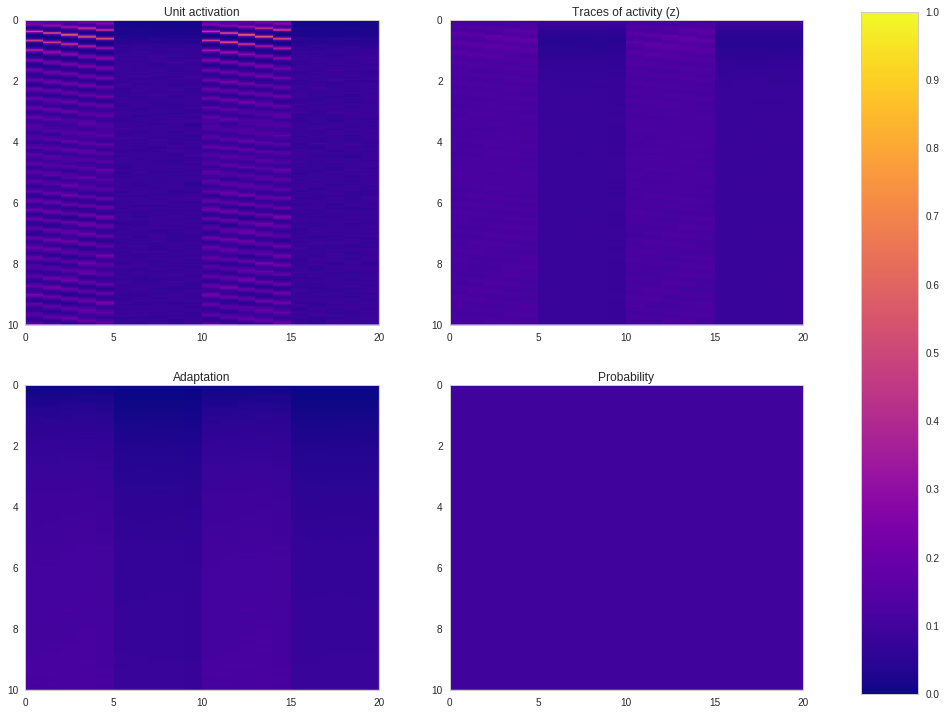

In [10]:
cmap = 'plasma'
extent = [0, minicolumns * hypercolumns, T_recalling, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(history['o'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(history['z_pre'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity (z)')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(history['a'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(history['p_pre'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

#### Git reset

In [11]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])